<a href="https://colab.research.google.com/github/noallynoclan/colab/blob/master/230319_waterfall.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LinearRegression
plt.style.use('default')

{'is_vo': 0.32568807339449535, 'is_an': -0.6559633027522934, 'global': 0.10550458715596323}


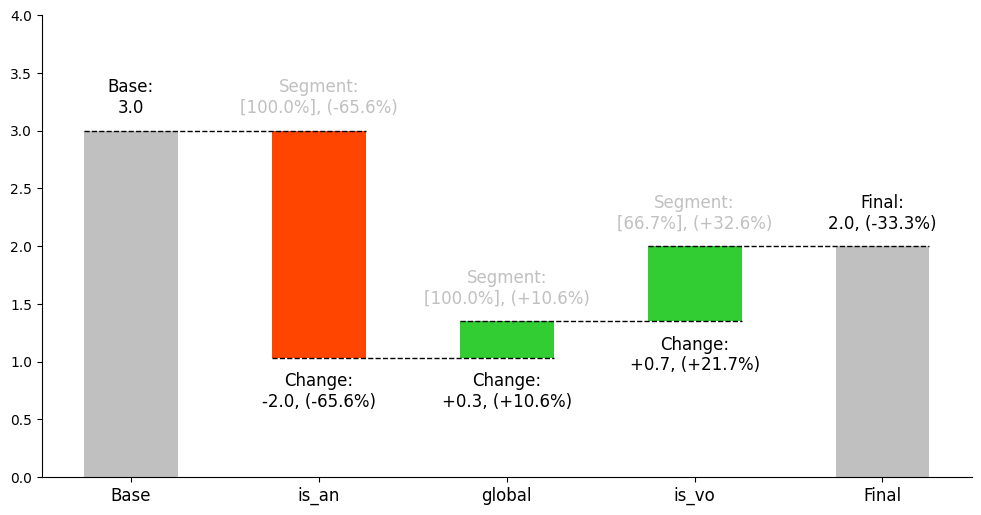

In [86]:
df = pd.DataFrame([
    [0, 0, 100, 110],
    [1, 0, 8, 12],
    [1, 1, 2, 1],
    [0, 1, 1, 1]
], columns = ['is_vo', 'is_an', 'pre', 'cur'])

class waterfall:
    def __init__(self, data):
        self._pre = 'pre'
        self._cur = 'cur'
        self._intercept = 'global'
        self.features = list(set(data.columns).difference([self._pre, self._cur]).union([self._intercept]))
        self.train_df = self.prep(data)
        self.coef = self.fit()
        
    def prep(self, data):
        df = data.copy()
        df[self._intercept] = 1
        df = df.groupby(self.features, as_index=False)[[self._pre, self._cur]].sum()
        df['y'] = df[self._cur] / df[self._pre] - 1
        df['w'] = df[self._pre] / df[self._pre].sum() * df[self._pre].count()
        return df[df[self._pre] > 0].copy()

    def fit(self):
        reg = LinearRegression(fit_intercept=False)
        reg.fit(self.train_df[self.features], self.train_df['y'], sample_weight=self.train_df['w'])
        coef = dict(zip(self.features, reg.coef_))
        print(coef)
        return coef

    def plot(self, data, w=0.5, size=12):
        df = self.prep(data)
        res = pd.DataFrame.from_dict({col: [df[df[col] == 1][self._pre].sum()] for col in self.coef.keys()}, 
                                     orient='index', columns=['segment'])
        res['coef'] = res.index.map(self.coef)
        res['impact'] = res['segment'] * res['coef']
        res = res.sort_values('impact')
        fig, ax = plt.subplots(1, 1, figsize=(12, 6))
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        pre = df[self._pre].sum()
        b = pre
        ax.bar(0, b, w, color='silver')
        ax.annotate(f'Base:\n{pre:.1f}', [0, b + 0.01 * size], fontsize=size, ha='center', va='bottom')
        for j, (i, row) in enumerate(res.iterrows(), start=1):
            h = row['impact']
            c = 'limegreen' if h > 0 else 'orangered'
            ax.bar(j, h, w, b, color=c)
            ax.plot([j - 1 - w / 2, j + w / 2], [b, b], c='k', ls='--', lw=1)
            ax.annotate(f'Segment:\n[{row["segment"] / pre:.1%}], ({row["coef"]:+.1%})', [j, max(b, b+h) + 0.01 * size], 
                        fontsize=size, ha='center', va='bottom', color='silver')
            ax.annotate(f'Change:\n{h:+.1f}, ({h/pre:+.1%})', [j, min(b, b+h) - 0.01 * size], 
                        fontsize=size, ha='center', va='top')
            b += h
        else:
            cur = df[self._cur].sum()
            ax.bar(j + 1, cur, w, color='silver')
            ax.plot([j - w / 2, j + 1 + w / 2], [b, b], c='k', ls='--', lw=1)
            ax.annotate(f'Final:\n{cur:.1f}, ({cur/pre-1:+.1%})', [j + 1, b + 0.01 * size], 
                        fontsize=size, ha='center', va='bottom')            
        ax.set_xticks(range(len(self.features) + 2), ['Base', *res.index, 'Final'], size=size)
        ax.set_ylim([ax.get_ylim()[0], ax.get_ylim()[1] + 1])



wf = waterfall(df)
wf.plot(df[df['is_an'] == 1])

In [137]:
df = pd.DataFrame([
    [0, 0, 100, 110],
    [1, 0, 8, 12],
    [1, 1, 2, 1]
], columns = ['is_vo', 'is_an', 'pre', 'cur'])


class waterfall:
    def __init__(self, data):
        self.features = set(col for col in data if col not in ['pre', 'cur']])
        self.df, self.features = self.prep(data)


    def prep(self, data):
        df = data.groupby(features, as_index=False)[[prev, cur]].sum()
        df = df[df[prev] > 0].copy()
        df['y'] = df[cur] / df[prev] - 1
        df['w'] = df[prev] / df[prev].sum() * df[prev].count()
        df['global'] = 1
        features.append('global')
        return df, features

    def fit():
        reg = LinearRegression(fit_intercept=False).fit(df[features], df['y'], sample_weight=df['w'])
        coef = dict(zip(features, reg.coef_))
        return coef

def waterfall(data, prev, cur, features):
    def prep(data, prev, cur, features):
        

    def fit(df, features):
        reg = LinearRegression(fit_intercept=False).fit(df[features], df['y'], sample_weight=df['w'])
        coef = dict(zip(features, reg.coef_))
        return coef

    df, features = prep(data, prev, cur, features)
    coef = fit(df, features)
    return coef


def plot(df, prev, cur, coef):
    res = pd.DataFrame.from_dict(
        {col: [df[df[col] == 1][prev].sum()] for col in coef.keys()}, 
        orient='index', columns=['segment'])
    res['coef'] = res.index.map(coef)
    res['impact'] = res['segment'] * res['coef']
    print(res)


    plot(df, None, coef)
    # df = df[df['is_vo'] == 1]
    # res = pd.DataFrame([
    #     ['prev', df[prev].sum(), 1],
    #     ['global', df[prev].sum(), reg.intercept_ - 1],
    #     *[[col, (df[prev] * df[col]).sum(), reg.coef_[i]] for i, col in enumerate(features)],
    #     ['cur', df[cur].sum(), None]
    # ], columns=['name', 'segment', 'coef'])
    # res['impact'] = res['segment'] * res['coef']

    # plot
    # fig, ax = plt.subplots(1, 1, figsize=(9, 6))
    # for i, row in res.iterrows():
    #     height = row['impact']
    #     color = 'limegreen' if height > 0 else 'orangered'
    #     ax.bar(i, row['impact'], 0.2, color=color)

    #return res

coef = fit_waterfall
waterfall(df, 'rev_pre', 'rev_cur', ['is_vo', 'is_an'])

{'is_vo': 0.3999999999999998, 'is_an': -1.0000000000000002, 'global': 0.09999999999999987}
        segment  coef  impact
is_vo        10   0.4     4.0
is_an         2  -1.0    -2.0
global      110   0.1    11.0
